## Constantes et modules

In [62]:
%matplotlib inline
import numpy as np
import timeit
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

### Question 1


<center><img src="schema_capaciteur.png" style="width: 600px;"/></center>
<center>Figure 1. Schéma du capaciteur [2]</center>


Pour employer la méthode de Gauss-Seidel, on doit ajouter à chaque itération à chaque élément la moyenne des éléments environnants de l'array. Quand la solution se sera "stabilisée", la différence entre chaque pas sera petite, ce qui permet d'arrêter la boucle lorsque la différence entre chaque pas atteint un certain seuil. Pour la méthode de Gauss-Seidel, on remplace directement les éléments dans l'array de solution *phi*.

Sachant que les parois sont à $V=0$ et que les plaques, indiquées sur la figure 1, sont à $V=\pm 1$, on peut écrire la fonction *gauss_seidel* suivante qui intialise l'array et qui calcule la solution:

À noter que ce code est directement inspiré de l'exemple donné dans les notes de cours du cours [2].

In [63]:
# BUT: Résoudre le problème du capaciteur électronique avec la méthode de Gauss-Seidel avec surrelaxation
# Arguments:
# M: nombre de carrés par côté dans l'array de la solution
# V: valeur absolue du potentiel de chaque plaque (la plaque gauche est négative et la plaque droite est positive) en volts
# omega: Facteur de surrelaxation
# target: précision recherchée

def gauss_seidel(M, V, omega, target):
    
    # On crée un array de dimension M+1 x M+1 (donc M carrés x M carrés)
    phi = np.zeros([M+1, M+1], float)

    # On initialise avec les conditions aux frontières, soit +/- V sur les plaques
    phi[20:81,20] = V
    phi[20:81,80] = -V

    # On initialise l'array dphi, soit la différence de chaque point avec sa valeur précédente
    dphi = np.zeros([M+1,M+1], float)

    delta = 1
    start = timeit.default_timer()

    # On boucle sur tous les éléments de phi tant que la différence maximale d'un pas est supérieure à target
    while delta > target:

        for i in range(1,M):
            for j in range(1,M):

                # Si le point est sur une des parois ou sur une des plaques, on remet la condition frontière

                # Les parois sont exclues de range(1,M)
                
                # Sur la plaque gauche
                if j==20 and i>=20 and i<=80:
                    phi[i,j] = V

                # Sur la plaque droite
                elif j==80 and i>=20 and i<=80:
                    phi[i,j] = -V

                # N'importe où ailleurs, on calcule la nouvelle valeur
                else: 
                    dphi[i,j] = (1+omega)*((phi[i+1,j]+phi[i-1,j]
                                            +phi[i,j+1]+phi[i,j-1])/4-phi[i,j])
                    phi[i,j] += dphi[i,j]

        # On calcule la différence maximale avec les anciennes valeurs
        delta = np.max(abs(dphi))

    end = timeit.default_timer()

    print(f"Temps d'éxécution pour Gauss-Seidel = {end-start:.3f} secondes")

    return phi

On peut aussi écrire une fonction *plot_solution* qu'on pourra appeler à chaque fois qu'on veut grapher la carte thermique de la solution:

In [64]:
# BUT: Grapher la solution obtenue par résolution numérique en carte thermique
# Arguments:
# phi: array solution
# method: string du nom de la méthode pour le titre du graphique

def plot_solution(phi, method):

    plt.imshow(phi)
    plt.title(f"Carte thermique de la solution avec la méthode de {method}")
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    plt.plasma()
    cbar = plt.colorbar()
    cbar.set_label("Potentiel [V]")
    plt.show()

Pour les problèmes #1 et #2, on souhaite avoir des carrés de solution de 100x100 ($M=100$), un potentiel sur les plaques de $V=\pm 1$, une précision de $1\times 10^{-5}$ et un facteur de surrelaxation de $\omega=0,9$ (seulement applicable dans le cas de la méthode de Gauss-Seidel; il est écrit dans l'énoncé d'employer la méthode de Gauss-Seidel avec surrelaxation, mais après discussion avec le professeur cela signifie la *sur*relaxation).

In [65]:
M = 100         # Nombre de carrés
V = 1           # Valeur absolue du potentiel des plaques
omega = 0.9     # Facteur de surrelaxation
target = 1e-6   # Précision recherchée

On obtient alors la solution avec la méthode de Gauss-Seidel:

Temps d'éxécution pour Gauss-Seidel = 7.073 secondes


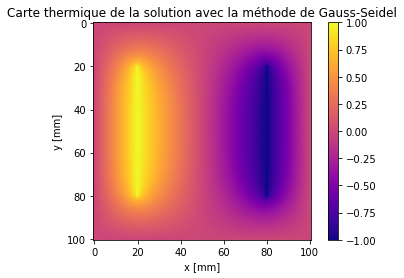

In [66]:
plot_solution(gauss_seidel(M, V, omega, target), "Gauss-Seidel")

### Question 2

On s'intéresse maintenant à la méthode de Jacobi, avec et sans slicing. La différence entre la méthode de Jacobi et celle de Gauss-Seidel est qu'alors que Gauss-Seidel modifie directement l'array de solution lorsqu'il calcule la nouvelle valeur, la méthode de Jacobi insère les nouvelles valeurs dans un array temporaire et rend cet array temporaire le nouvel array solution à la fin de l'itération. Cela a pour effet de, théoriquement, faire converger Gauss-Seidel plus rapidement étant donné que certaines des valeurs utilisées pour calculer un nouveau pas ont été mises à jour au préalable. Vérifions si cette hypothèse est correcte:

Note: pour les méthodes de Jacobi, il arrive parfois que le calcul ne fonctionne pas, mais nous n'avons aucune idée pourquoi. Parfois, l'array solution sera rempli d'une valeur unique, parfois le calcul se poursuivra indéfiniment sans trouver de solution, mais nous n'avons pas été capable d'identifier la raison. Généralement, redémarrer Visual Studio Code est suffisant, et nous finissons toujours par obtenir la solution correcte.

In [67]:
# BUT: Résoudre le problème du capaciteur électronique avec la méthode de Jacobi
# Arguments:
# M: nombre de carrés par côté dans l'array de la solution
# V: valeur absolue du potentiel de chaque plaque (la plaque gauche est négative et la plaque droite est positive) en volts
# target: précision recherchée

def jacobi(M, V, target):

    # On crée un array de dimension M+1 x M+1 (donc M carrés x M carrés)
    phi = np.zeros([M+1, M+1], float)
    phiprime = np.zeros([M+1, M+1], float)

    # On initialise avec les conditions aux frontières, soit +/- V sur les plaques
    phi[20:81,20] = V
    phi[20:81,80] = -V

    delta = 1

    start = timeit.default_timer()

    # On boucle sur tous les éléments de phi tant que la différence maximale d'un pas est supérieure à target
    while delta > target:

        for i in range(1,M):
            for j in range(1,M):

                # Si le point est sur une des parois ou sur une des plaques, on remet la condition frontière

                # Les parois sont exclues de range(1,M)
                
                # Sur la plaque gauche
                if j==20 and i>=20 and i<=80:
                    phiprime[i,j] = V

                # Sur la plaque droite
                elif j==80 and i>=20 and i<=80:
                    phiprime[i,j] = -V

                # N'importe où ailleurs, on calcule la nouvelle valeur
                else:
                    phiprime[i,j] = (phi[i+1,j]+phi[i-1,j]+phi[i,j+1]+phi[i,j-1])/4

        # On calcule la différence maximale avec les anciennes valeurs
        delta = np.max(abs(phiprime-phi))

        # On échange les arrays pour la prochaine itération
        phi, phiprime = phiprime, phi

    end = timeit.default_timer()

    print(f"Temps d'éxécution pour Jacobi sans slicing = {end-start:.3f} secondes")

    return phi



Temps d'éxécution pour Jacobi sans slicing = 48.428 secondes


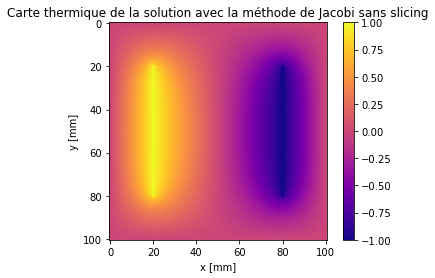

In [68]:
plot_solution(jacobi(M, V, target), "Jacobi sans slicing")

Effectivement, il faut beaucoup plus longtemps pour calculer la solution avec Jacobi sans slicing qu'avec Gauss-Seidel. Vérifions maintenant Jacobi avec slicing.

Pour ce faire, au lieu d'itérer sur tous les éléments individuellement pour les mettre à jour, on sélectionne la portion centrale de l'array, et on lui ajoute la moyenne des portions adjacentes. Il y a donc un seul "gros" calcul à faire au lieu de beaucoup de petits. Vérifions quel est l'effet sur le temps d'éxécution:

In [69]:
# BUT: Résoudre le problème du capaciteur électronique avec la méthode de Jacobi avec le slicing
# Arguments:
# M: nombre de carrés par côté dans l'array de la solution
# V: valeur absolue du potentiel de chaque plaque (la plaque gauche est négative et la plaque droite est positive) en volts
# target: précision recherchée

def jacobi_slicing(M, V, target):

    # On crée un array de dimension M+1 x M+1 (donc M carrés x M carrés)
    phi = np.zeros([M+1, M+1], float)
    phiprime = np.zeros([M+1, M+1], float)

    # On initialise avec les conditions aux frontières, soit +/- V sur les plaques
    phi[20:81,20] = V
    phi[20:81,80] = -V

    delta = 1
    start = timeit.default_timer()

    # On boucle tant que la différence maximale d'un pas est supérieure à target
    while delta > target:

        # Pour chaque valeur excluant les parois, on additionne la moyenne des points environnants avec le slicing
        phiprime[1:M,1:M] = (phi[2:M+1,1:M]+phi[0:M-1,1:M]+phi[1:M,2:M+1]+phi[1:M,0:M-1])/4

        # On replace les conditions frontières sur les plaques (les parois ne changent pas dans l'équation précédente)
        phiprime[20:81,20] = V
        phiprime[20:81,80] = -V

        # On calcule la différence maximale avec le pas précédent
        delta = np.max(abs(phiprime-phi))

        # On échange les array pour la prochaine itération
        phi, phiprime = phiprime, phi

    end = timeit.default_timer()

    print(f"Temps d'éxécution pour Jacobi avec slicing = {end-start:.3f} secondes")

    return phi

Temps d'éxécution pour Jacobi avec slicing = 0.199 secondes


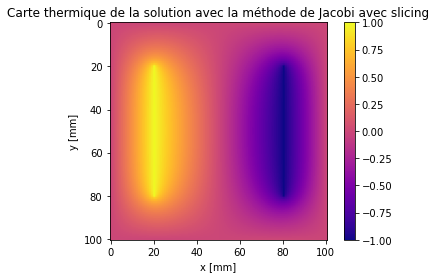

In [70]:
plot_solution(jacobi_slicing(M, V, target), "Jacobi avec slicing")

Les temps d'éxécution approximatifs (arrondis à la seconde près pour une éxécution sur notre ordinateur personnel) pour les trois méthodes sont:

Gauss-Seidel:           7 secondes

Jacobi sans slicing:    48 secondes

Jacobi avec slicing:    <1 seconde

On constate donc que, conformément à notre hypothèse de départ, Gauss-Seidel est plus rapide que Jacobi sans slicing, prenant environ $15\%$ du temps requis par Jacobi pour le calcul. Cependant, Jacobi avec slicing est beaucoup plus performant que les deux autres méthodes, prenant moins d'une seconde pour effectuer le calcul (0,2 secondes lorsque nous l'avons testé). 

Il peut aussi être intéressant (bien que ça ne soit pas explicitement demandé) de vérifier si on obtient les mêmes solutions pour chaque méthode. On peut utiliser la fonction *array_equal* de numpy, qui vérifie si deux array sont identiques et retourne un booléen:

In [71]:
phi1 = gauss_seidel(M, V, omega, target)
phi2 = jacobi(M, V, target)
phi3 = jacobi_slicing(M, V, target)

print(f"Gauss-Seidel et Jacobi sans slicing: {np.array_equal(phi1, phi2)}")
print(f"Gauss-Seidel et Jacobi avec slicing: {np.array_equal(phi1, phi3)}")
print(f"Jacobi avec et sans slicing: {np.array_equal(phi2, phi3)}")

Temps d'éxécution pour Gauss-Seidel = 7.677 secondes
Temps d'éxécution pour Jacobi sans slicing = 50.108 secondes
Temps d'éxécution pour Jacobi avec slicing = 0.216 secondes
Gauss-Seidel et Jacobi sans slicing: False
Gauss-Seidel et Jacobi avec slicing: False
Jacobi avec et sans slicing: True


On constate que les solutions de Jacobi avec et sans slicing sont identiques, mais pas celles de Gauss-Seidel et de Jacobi (peu importe l'usage de slicing ou non). Ce résultat est parfaitement logique: Gauss-Seidel avec surrelexation est un algorithme différent de celui de Jacobi de par l'utilisation de la surrelaxation. Étant donné que les deux algorithmes ne convergent pas de la même manière, il est normal que les solutions diffèrent légèrement l'une de l'autre. Plus la valeur de *target* est petite, plus la différence sera minime (théoriquement, si *target* était nul et qu'on pouvait avoir une précision numérique infinie en un nombre d'itérations fini, on convergerait vers la même solution).

Il est aussi logique que Jacobi avec et sans slicing convergent vers la même solution, étant donné qu'ils emploient exactement le même algorithme: la seule différence est que, pour Jacobi sans slicing, tous les éléments sont traités séparément, tandis qu'avec slicing ils sont traités en bloc.

## FTCS et l’équation d’onde

### Question 3

On veut caractériser les oscillations d'une corde de piano de longueur $L$ fixée aux deux bouts. La corde est frappée par un marteau à une distance $d$ d'une de ses extrémités. La situation est représentée à la figure 2.

<center><img src="Q3_schéma.JPG" style="width: 600px;"/></center>
<center>Figure 2. Corde de piano frappée par un marteau (question 3 à 6) [1]

On sait que le comportement de la corde tendue respecte l'équation d'onde en une dimension. L'équation d'onde à une dimension correspond à :
$$\frac{\partial^2\phi}{\partial t^2} = v^2\frac{\partial^2\phi}{\partial x^2}$$
On doit adapter cette équation afin de pouvoir la résoudre numériquement. Pour ce faire, on divise la corde en $N$ petits intervalles de longueur $a$. La dérivée par rapport à $x$ peut alors être approximée par une forme discrète :
$$\frac{\partial^2\phi}{\partial x^2} = \frac{1}{a^2}[\phi(x+a,t) + \phi(x-a, t) - 2\phi(x,t)]$$
En remplaçant dans l'équation d'onde, on obtient l'équation différentielle totale suivante :
$$\frac{\partial^2\phi}{\partial t^2} = \frac{v^2}{a^2}[\phi(x+a,t) + \phi(x-a, t) - 2\phi(x,t)]$$
On veut maintenant convertir l'équation différentielle d'ordre 2 en un système de 2 équations différentielles d'ordre 1. En posant le changement de variable $\psi(x,t) = \frac{\text{d}\phi}{\text{d}t}$, on obtient le système d'équations suivant :
$$\psi(x,t) = \frac{\text{d}\phi}{\text{d}t}$$
$$\frac{\text{d}\psi}{\text{d}t} = \frac{v^2}{a^2}[\phi(x+a,t) + \phi(x-a, t) - 2\phi(x,t)]$$
En utilisant la méthode d'Euler avec un pas temporel $h$, on obtient les équations FTCS suivantes :
$$\phi(x,t+h) = \phi(x, t) + h\psi(x, t)$$
$$\psi(x, t+h) = \psi(x, t) + h\frac{v^2}{a^2}[\phi(x+a,t) + \phi(x-a, t) - 2\phi(x,t)]$$
On peut maintenant déterminer numériquement le comportement de la corde pour les conditions initiales données dans l'énoncé.  On a donc une corde de longueur $L=1$ m, de diamètre $d=10$ cm, avec $v=100\ \text{ms}^{-1}$. Initialement, on a $\phi(x)=0$ et
$$\psi(x) = C\frac{x(L-x)}{L^2}e^{-\frac{(x-d)^2}{2\sigma^2}}$$
où $C=1\ \text{ms}^{-1}$ et $\sigma = 0,3$ m.

On code la fonction *corde_FTCS*. Cette fonction prend en argument les *arrays* *phi_0* [m] et *psi_0* [m/s], qui correspondent respectivement aux conditions initiales $\phi(x)$ et $\psi(x)$, ainsi que la longueur *L* [m] de la corde, le nombre *N* de tranches spatiales, la valeur finale de temps *t_f* [s] qui nous intéresse, le nombre *N_t* de tranches temporelles et la valeur du paramètre *v* [$\text{s}^{-1}$]. La fonction détermine d'abord la valeur des pas temporel *h* et spatial *a* à partir des valeurs de *L*, *N*, *t_f* et *N_t*. La fonction utilise ensuite les équations FTCS déterminées plus haut afin de calculer de manière itérative les valeurs de $\phi$ et de $\psi$ pour chaque valeur de temps $t$. Elle retourne ensuite les valeurs de temps *t* dans un *array numpy* à une dimension et les valeurs de *phi* et de *psi* séparément dans deux *arrays numpy* à 2 dimensions où chaque ligne représente un incrément de temps.

In [72]:
# Méthode FTCS pour déterminer le comportement de la corde
# Arguments:
# phi_0 : array 1D des valeurs initiales de phi [m]
# psi_0 : array 1D des valeurs initiales de psi [m/s]
# L : longueur de la corde [m]
# N : nombre de divisions en x [-]
# t_f : valeur maximale de temps [s]
# N_t : nombre de divisions en t [-]
# v : valeur du paramètre v [s^(-1)]
# Retourne :
# t : array numpy 1D représentant les valeurs de temps [s]
# phi : array numpy 2D des valeurs de phi ou chaque rangée est associée 
#       à une valeur de temps et chaque colonne à une position [m]
# psi : array numpy 2D des valeurs de psi ou chaque rangée est associée 
#       à une valeur de temps et chaque colonne à une position [m/s]

def corde_FTCS(phi_0, psi_0, L, N, t_f, N_t, v):
    # pas temporel et spatial
    h = t_f / N_t
    a = L / N
    
    # variables indépendantes
    t = np.linspace(0, t_f, N_t)
    x = np.linspace(0, L, N)

    # valeurs initiales en listes
    phi = [list(phi_0)]
    psi = [list(psi_0)]

    # processus itératif en listes (zéro au début et à la fin pour les bouts fixes)
    for i in range(len(t)):
        psi_i = [0]
        phi_i = [0]
        for j in range(len(x))[1:-1]:
            phi_j = phi[i][j] + h*psi[i][j]
            psi_j = psi[i][j] + h*v**2/a**2 * (phi[i][j+1] + phi[i][j-1] - 2*phi[i][j])
            phi_i.append(phi_j)
            psi_i.append(psi_j)
        phi_i.append(0)
        psi_i.append(0)
        phi.append(phi_i)
        psi.append(psi_i)
    
    # conversion en array
    return t, np.array(phi), np.array(psi)

On peut maintenant déterminer le comportement de la corde de $t=0$ à $t=100$ ms pour les valeurs de paramètres et les valeurs initiales données.

In [73]:
# données
L = 1
N = 100
t_f = 0.1
h = 10**(-6)
N_t = int(t_f / h)
C = 1
d = 0.1
sigma = 0.3
v = 100

# conditions initiales
init_phi = np.zeros(N)
x = np.linspace(0, L, N)
init_psi = C*x*(L-x) / L**2 * np.exp(-(x-d)**2 / (2*sigma**2))

t, phi, psi = corde_FTCS(init_phi, init_psi, L, N, t_f, N_t, v)

On représente graphiquement la position de la corde au temps $t=100$ ms.

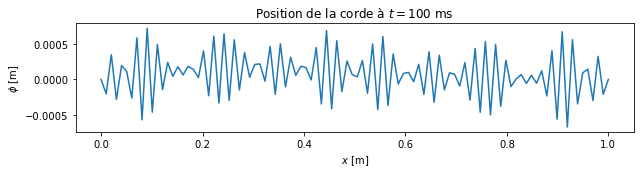

In [74]:
# représentation graphique à t=0.1
fig1 = plt.figure(figsize=(10, 2))
fig1.patch.set_facecolor('white')
plt.xlabel('$x$ [m]')
plt.ylabel('$\phi$ [m]')
plt.plot(x, phi[-1])
plt.title("Position de la corde à $t=100$ ms")
plt.show()

Ce résultat, qui ne correspond pas à ce à quoi on s'attend physiquement, semble indiquer que la solution donnée par la méthode FTCS s'éloigne de la solution physique lorsque le temps avance. On pourra mieux observer ce comportement à la question 4 grâce à une animation.

### Question 4

On veut maintenant observer le comportement de la corde dans l'intervalle de temps. Pour ce faire, on veut représenter les résultats obtenus à la question 3 dans une animation. Pour ce faire, on utilise la fonction *FuncAnimation* du module *matplotlib.animation*. Afin d'avoir une animation et un temps de calcul tous deux d'une durée raisonnable, on choisit de tracer seulement 1 itération temporelle sur 100. On aura donc 1000 images à générer pour animer la corde de 0 à 100 ms. On sauvegarde l'animation et on la fait apparaître dans le *notebook*.

FileNotFoundError: [WinError 2] The system cannot find the file specified

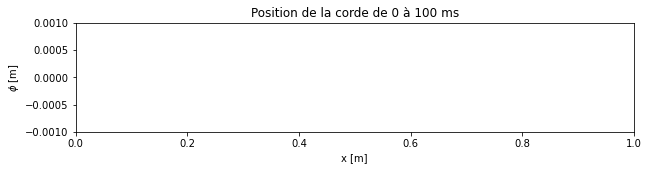

In [75]:
# création de la figure et la ligne qui contiendra les données
fig2 = plt.figure(figsize=(10,2))
fig2.patch.set_facecolor('white')
ax = plt.axes(xlim=(0, 1), ylim=(-0.001, 0.001))
line, = ax.plot([], [], lw=2)
plt.xlabel("x [m]")
plt.ylabel("$\phi$ [m]")
plt.title("Position de la corde de 0 à 100 ms")

# 1 frame pour 100 itérations temporelles
phi_anim = phi[::200]
psi_anim = psi[::200]

# fonction d'initialisation
def fonc_init():
    line.set_data([], [])
    return line,

# fonction d'animation
def anim(i):
    x = np.linspace(0, 1, 100)
    y = phi_anim[i]
    line.set_data(x, y)
    return line,

# animation
corde1 = FuncAnimation(fig2, anim, init_func=fonc_init, frames=500, interval=10, repeat=True)

# sauvegarde (ATTENTION: si FFMpeg n'est pas dans les paths, le code ne compilera pas)
writervideo = FFMpegWriter(fps=30)
corde1.save("corde1.mp4", writer=writervideo)

plt.show()

On remarque que le comportement de la corde suit initialement le comportement prévu physiquement. En effet, on observe une déformation qui part du point où le marteau frappe la corde et qui se propage le long de celle-ci en étant réfléchie aux extrémités. Puis, de petites oscillations non-physiques commencent à apparaître. Ces oscillations deviennent de plus en plus grandes jusqu'à ce qu'elles soient de taille comparable au mouvement du début de l'animation. On voit donc très bient que la méthode FTCS donne, dans ce cas-ci, une solution qui diverge de la vraie solution lorsque le temps avance.

### Question 5

Maintenant que nous avons observé le comportement de la corde tel que prédit par la méthode FTCS, on veut en analyser la stabilité. Pour ce faire, on peut utiliser la méthode de von Newmann. La démarche pour déterminer la stabilité de la méthode FTCS appliquée à l'équation d'onde est présentée en détails dans la section 9.3.2 de *Computational Physics - Revised and expanded* par Mark Newman. Tout d'abord, on représente nos 2 équations FTCS en séries de Fourier. On regroupe alors les coefficients de Fourier des deux équations en un vecteur pour chaque terme de la série. On peut maintenant représenter l'évolution du vecteur des coefficients de Fourier $\boldsymbol{c}(t)$ grâce à un opérateur linéaire $A$ de la façon suivante :
$$\boldsymbol{c}(t+h) = A\boldsymbol{c}(t)$$
On peut représenter le vecteur $\boldsymbol{c}(t)$ en fonction des vecteurs propres $v_i$ de l'opérateur $A$ :
$$\boldsymbol{c}(t) = \alpha_1v_1 + \alpha_2v_2$$
où $\alpha_1$ et $\alpha_2$ sont des constantes. On peut maintenant représenter l'équation d'une itération temporelle de la façon suivante :
$$\boldsymbol{c}(t+h) = \alpha_1\lambda_1v_1 + \alpha_2\lambda_2v_2$$
où $\lambda_i$ est la valeur propre de $A$ associée au vecteur propre $v_i$. On remarque donc que les vecteurs propres sont simplement multipliés par la même constante à chaque itération. On aura donc une solution qui ne diverge pas seulement si $|\lambda_1|,|\lambda_2|\leq 1$. Sinon, les vecteurs propres seront multipliés par une valeur plus grande que l'unité à chaque itération et les coefficients vont simplement augmenter jusqu'à tendre vers l'infini. Dans notre cas, les valeurs propres respectent l'expression suivante :
$$|\lambda| = \sqrt{1 + \frac{4h^2v^2}{a^2}\sin^2\frac{ka}{2}}$$
Comme cette expression est toujours plus grande que 1, on voit que la méthode FTCS diverge toujours lorsqu'on l'utilise pour résoudre l'équation d'onde. Ce résultat explique les instabilités observées aux question 3 et 4 qui apparaissent après un certain temps. Si on laissait la simulation continuer pour des valeurs de temps plus élevées, on obtiendrait des instabilités toujours de plus en plus grandes.

### Question 6

Vu l'échec de la méthode FTCS pour résoudre l'équation d'onde, on essaie maintenant la méthode de Crank-Nicolson. Pour l'équation d'onde à une dimension, les équations de la méthode de Crank-Nicolson correspondent à :
$$\phi(x,t+h) - \frac{1}{2}h\psi(x,t+h) = \phi(x,t) + \frac{1}{2}h\psi(x,t)$$
$$\psi(x,t+h) - h\frac{v^2}{2a^2}[\phi(x+a,t+h) + \phi(x-a,t+h) - 2\phi(x,t+h)] = \psi(x,t) + h\frac{v^2}{2a^2}[\phi(x+a,t) + \phi(x-a,t) - 2\phi(x,t)]$$
Comme les équations ne donnent pas explicitement $\phi$ et $\psi$, on doit les déterminer en résolvant le système d'équations linéaires formé par les équations.

On crée alors la méthode *corde_CN*, qui prend en argument les valeurs initiales *phi_0* et *psi_0* sous forme d'*arrays* 1D, la longueur *L* de la corde en mètres, le nombre *N* de divisions spatiales de la corde, la valeur maximale de temps *t_f* en secondes, le nombre *N_t* d'itérations temporelles et le paramètre *v* de l'équation différentielle en $\text{s}^{-1}$. En premier lieu, la fonction définit les pas temporel *h* et spatial *a*, crée les arrays 1D des variables de temps et d'espace et convertit les conditions initiales en listes. Ensuite, le processus itératif commence. Pour chaque itération temporelle, la fonction doit créer les matrices qui représentent le système d'équaitons linéaires des $2N-4$ équations de Crank-Nicolson (on a 2 équations par position $x$ excepté les deux bouts fixés en hauteur et en vitesse à 0). Pour ce faire, deux *array* sont créés à chaque itération. Le premier contient les coefficients des $\phi(x, t+h)$ et $\psi(x, t+h)$ des parties gauches des équations de Crank-Nicolson pour chaque valeur de $x$ qui n'est pas fixée à 0. Chaque ligne correspond à une équation différente et chaque colonne correspond à une hauteur ou à une vitesse pour une position donnée sur la corde. Les colonnes sont ordonnées de $x=0$ à $x=L$ d'abord pour $\phi(x,t+h)$ et ensuite pour $\psi(x, t+h)$. Les bouts fixés à 0 sont exclus de l'*array* avant de procéder à la résolution du système. L'autre *array* utilisé pour résoudre le système est simplement un array 1D des résultats de la partie de droite de chaque équation de Crank-Nicolson. Évidemment, la position de chaque résultat concorde avec la ligne de la même équation dans l'*array* des coefficients. La fonction crée donc, pour chaque itération temporelle et avec des *arrays* *numpy*, le système d'équation qui peut être vu sous forme matricielle de la façon suivante:

\begin{bmatrix}
1&0&\dots&0&-\frac{1}{2}h&0&\dots&0\\
h\frac{v^2}{2a^2}&-h\frac{v^2}{2a^2}&\dots&0&1&0&\dots&0\\
0&1&\dots&0&0&-\frac{1}{2}h&\dots&0\\
-h\frac{v^2}{2a^2}&h\frac{v^2}{2a^2}&\dots&0&0&1&\dots&0\\
\vdots\\
0&0&\dots&1&0&0&\dots&-\frac{1}{2}h\\
0&0&\dots&h\frac{v^2}{2a^2}&0&0&\dots&1\\
\end{bmatrix}\begin{bmatrix}\phi(a,t+h)\\\phi(2a,t+h)\\\vdots\\\phi(L-a,t+h)\\\psi(a,t+h)\\\psi(2a,t+h)\\\vdots\\\psi(L-a,t+h)\end{bmatrix}=\begin{bmatrix}C_1\\C_2\\\vdots\\C_{N-2}\\C_{N-1}\\C_{N}\\\vdots\\C_{2N-4}\\\end{bmatrix}

où les $C_n$ représentent les valeurs numériques des parties de droite des équations de Crank-Nicolson. La fonction résoud ensuite le système d'équations en utilisant *linalg.solve* de *numpy*, qui utilise la méthode de la décomposition LU. À la fin du processus itératif, les valeurs de $\phi$ et de $\psi$ sont retournées séparément dans deux *arrays* 2D où chaque colonne représente une position $x$ et chaque ligne représente un temps $t$. Les 0 des bouts fixes sont également réintroduits dans les *arrays* à la fin du processus.


In [ ]:
# CRANK-NICOLSON
#
# Arguments:
# phi_0 : valeurs initiales de phi sous forme de liste [m]
# phi_0 : valeurs initiales de psi sous forme de liste [m/s]
# L : longueur de la corde [m]
# N : nombre de divisions spatiales [-]
# t_f : valeur maximale de temps [s]
# N_t : nombre d'itérations temporelles [-]
# v : paramètre v de l'équation d'onde [s^(-1)]
#
# Retourne:
# t : valeurs temporelles dans un array numpy 1D [s]
# phi : valeurs de phi dans un array numpy 2D [m]
# psi : valeurs de psi dans un array numpy 2D [m/s]

def corde_CN(phi_0, psi_0, L, N, t_f, N_t, v):
    # pas temporel et spatial
    h = t_f / N_t
    a = L / N
    
    # variables indépendantes
    t = np.linspace(0, t_f, N_t)
    x = np.linspace(0, L, N)

    # valeurs initiales en listes
    phi = [list(phi_0)]
    psi = [list(psi_0)]

    # constantes pour simplifier les calculs
    b = h * v**2 / (2*a**2)
    lenx = len(x)

    # processus iteratif
    for i in range(len(t)):
        coeffs = []
        somme = []

        for j in range(lenx)[1:-1]:

            # première équation de C-N
            coeffs_j_1 = [0 for n in range(2*lenx)]
            coeffs_j_1[j] = 1
            coeffs_j_1[lenx + j] = -1/2*h
            somme_j_1 = phi[i][j] + 1/2*h * psi[i][j]

            # bouts fixes
            del(coeffs_j_1[0], coeffs_j_1[lenx-2:lenx], coeffs_j_1[-1])

            coeffs.append(coeffs_j_1)
            somme.append(somme_j_1)

            # deuxième équation de C-N
            coeffs_j_2 = [0 for n in range(2*lenx)]
            coeffs_j_2[j-1] = -b
            coeffs_j_2[j] = 2*b
            coeffs_j_2[j+1] = -b
            coeffs_j_2[lenx + j] = 1
            somme_j_2 = psi[i][j] + b * (phi[i][j+1] + phi[i][j-1] - 2*phi[i][j])

            # bouts fixes
            del(coeffs_j_2[0], coeffs_j_2[lenx-2:lenx], coeffs_j_2[-1])

            coeffs.append(coeffs_j_2)
            somme.append(somme_j_2)

        # formattage pour la résolution
        coeffs_array = np.array(coeffs)
        somme_array = np.array(somme)

        # résolution du système d'équations
        result = np.linalg.solve(coeffs_array, somme_array)

        phi.append([0] + list(result[:lenx-2]) + [0])
        psi.append([0] + list(result[lenx-2:]) + [0])
    
    return t, phi, psi


On peut maintenant utiliser les mêmes données qu'auparavant pour déterminer le résultat donné par notre nouvelle fonction utilisant la méthode de Crank-Nicolson. Comme la méthode de Crank-Nicolson est un peut plus lourde que la méthode FTCS, on utilise un pas temporel $h=10^{-5}$, soit 10 fois plus grand que pour la méthode FTCS, afin de limiter le temps de calcul.

In [ ]:
# données
L = 1
N = 100
t_f = 0.1
h = 10**(-5)
N_t = int(t_f / h)
C = 1
d = 0.1
sigma = 0.3
v = 100

# conditions initiales
init_phi = np.zeros(N)
x = np.linspace(0, L, N)
init_psi = C*x*(L-x) / L**2 * np.exp(-(x-d)**2 / (2*sigma**2))

t_CN, phi_CN, psi_CN = corde_CN(init_phi, init_psi, L, N, t_f, N_t, v)

On peut maintenant créer une animation du résultat en utilisant le même code que pour l'animation des résultats donnés par la méthode FTCS.

In [ ]:
# création de la figure et la ligne qui contiendra les données
fig3 = plt.figure(figsize=(10,2))
fig3.patch.set_facecolor('white')
ax = plt.axes(xlim=(0, 1), ylim=(-0.001, 0.001))
line, = ax.plot([], [], lw=2)
plt.xlabel("x [m]")
plt.ylabel("$\phi$ [m]")
plt.title("Position de la corde de 0 à 100 ms")

# 1 frame pour 20 itérations temporelles
phi_anim_CN = phi_CN[::20]
psi_anim_CN = psi_CN[::20]

# fonction d'initialisation
def fonc_init():
    line.set_data([], [])
    return line,

# fonction d'animation
def anim(i):
    x = np.linspace(0, 1, 100)
    y = phi_anim_CN[i]
    line.set_data(x, y)
    return line,

# animation
corde2 = FuncAnimation(fig3, anim, init_func=fonc_init, frames=500, interval=10, repeat=True)

# sauvegarde (ATTENTION: si FFMpeg n'est pas dans les paths, le code ne compilera pas)
writervideo = FFMpegWriter(fps=30)
corde2.save("corde2.mp4", writer=writervideo)

plt.show()

On voit que les perturbations non-physiques qui apparaissaient dans les résultats donnés par la méthode FTCS ne sont pas présentes dans les résultats donnés par la méthode de Crank-Nicolson, même si nous avons utilisé un pas temporel 10 fois plus grand ici. Toutefois, on veut aussi s'assurer que la méthode ne diverge pas pour des valeurs de $t$ plus grandes. On veut donc prouver que la méthode de Crank-Nicolson converge pour l'équation d'onde.

Pour vérifier que la méthode de Crank-Nicholson est stable, on peut recourir à l'analyse de von Neumann, comme nous avons fait dans le cas de la méthode FTCS. La démarche est faite dans le Newman au chapitre 9.3.3.

Puisque le système d'équations demeure le même, on a la même forme de solution que pour la méthode FTCS, c'est-à-dire:

$$\begin{pmatrix}\phi(x,t)\\\psi(x,t)\end{pmatrix}=\begin{pmatrix}c_\phi(t)\\c_\psi(t)\end{pmatrix}e^{ikx}$$

Cette fois-ci, cependant, la forme nous donnant les coefficients de Fourier $c(t)$ est (équation 9.50):

$$\mathbf{c}(t+h)=\mathbf{B}^{-1}\mathbf{A}\mathbf{c}(t)$$

On peut refaire le même raisonnement que précédemment. On cherche les valeurs propres du système, et si celles-ci sont plus petites ou égales à un, la méthode est stable. Or, l'expression des valeurs propres dans ce cas-ci est donnée directement dans le Newman, soit (équation 9.54):

$$|\lambda|=\frac{\sqrt{(1-h^2r^2+2ihr)(1-h^2r^2-2ihr)}}{1+h^2r^2}=1$$

Étant donné que les valeurs propres (en valeur absolue) sont toujours égales à 1, peu importe les valeurs de $h$ et $r$, on peut en conclure que la méthode de Crank-Nicholson pour le calcul de l'équation d'onde est toujours numériquement stable.

### Médiagraphie

[1] PHY-3500, énoncé du travail pratique 4

[2] PHY-3500, notes de cours, équations différentielles partielles, exercice 9.2